In [1]:
%load_ext autoreload
%autoreload 2

## Importing relevant packages for finetuning

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_PMAP_USE_TENSORSTORE'] = 'false'

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            print('=== setting gpu memory growth to True for gpu: ', gpu)
            tf.config.experimental.set_memory_growth(gpu, True) 
    except RuntimeError as e:
        print(e)

2025-02-09 23:28:08.158318: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 23:28:08.162893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-09 23:28:08.162908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-09 23:28:10.546376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-09 23:28:10.546437: W tensorflow/stream_executor/platform/default/dso_loader.cc:

In [3]:
import timesfm
import gc 
from timesfm import patched_decoder
from timesfm import data_loader

TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


In [4]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Loading TimesFM pretrained checkpoint

In [25]:
timesfm_backend = "gpu"  # @param

tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend=timesfm_backend,
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          # Se this to True for v1.0 checkpoints
          use_positional_embedding=False,
          # Note that we could set this to as high as 2048 but keeping it 512 here so that
          # both v1.0 and 2.0 checkpoints work
          context_len=512,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-jax"),
  )

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

2025-02-09 23:56:44.617019: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Multiprocessing context has already been set.
Constructing model weights.


Constructed model weights in 7.64 seconds.
Restoring checkpoint from /home/fenrir/.cache/huggingface/hub/models--google--timesfm-2.0-500m-jax/snapshots/47dedfcadf2abace1cc96071ddb798cfcd3bfcef/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 3.54 seconds.
Jitting decoding.
Jitted decoding in 58.35 seconds.


# Build complex series

In [5]:
from sum_time_series import parallel_generate_series

def create_series():
    series_length = 36000
    n_series_range = range(100, 1001, 100)
    num_rep = 1
    exp = -1.0001
    freq_range = (0.000001, 500)
    serie_generate, _, _ = parallel_generate_series(n_series_range, num_rep, series_length, 1, exp, freq_range, 1)

    return serie_generate

In [6]:
serie_generate = create_series()

/home/fenrir/mambaforge/envs/timesfm/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/fenrir/mambaforge/envs/timesfm/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [7]:
serie_generate.keys()

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

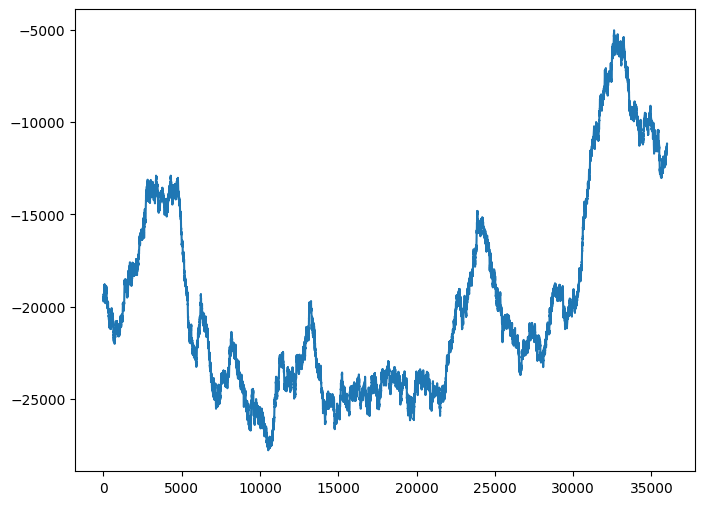

In [9]:
plt.plot(serie_generate[1000][0][:])

## Evaluating pretrained checkpoint

In [10]:
s = serie_generate[1000][0]
s.shape

(36000,)

In [11]:
serie = {'date_int':list(range(len(s))), '500':s}

In [12]:
data_df = pd.DataFrame(serie)#, columns=[])
# Scegli una data di partenza (es: 1 Gennaio 2023)
data_partenza = "2003-01-01"
# Converti gli interi in giorni a partire da 'data_partenza'
data_df["date"] = pd.to_datetime(data_df["date_int"], unit="m", origin='unix')
data_df = data_df[['date','500']]

freq = '1min'
boundaries = [28000, 31000, 36000]
ts_cols = ['500']
context_len = 512
pred_len = 96
num_ts = 1
batch_size = 32

In [20]:
data_df.to_csv('serie_500.csv')

In [21]:
#pd.read_csv(open('serie_500.csv', "r"))

In [20]:
num_cov_cols = None
cat_cov_cols = None

dtl = data_loader.TimeSeriesdata(
      data_path="serie_500.csv",
      datetime_col="date",
      num_cov_cols=num_cov_cols,
      cat_cov_cols=cat_cov_cols,
      ts_cols=np.array(ts_cols),
      train_range=[0, boundaries[0]],
      val_range=[boundaries[0], boundaries[1]],
      test_range=[boundaries[1], boundaries[2]],
      hist_len=context_len,
      pred_len=pred_len,
      batch_size=num_ts,
      freq=freq,
      normalize=True,
      epoch_len=None,
      holiday=False,
      permute=True,
  )

In [21]:
train_batches = dtl.tf_dataset(mode="train", shift=1).batch(batch_size)
val_batches = dtl.tf_dataset(mode="val", shift=pred_len)
test_batches = dtl.tf_dataset(mode="test", shift=pred_len)

In [22]:
for tbatch in tqdm(train_batches.as_numpy_iterator()):
    break
print(tbatch[0].shape)

0it [00:00, ?it/s]

(32, 1, 512)


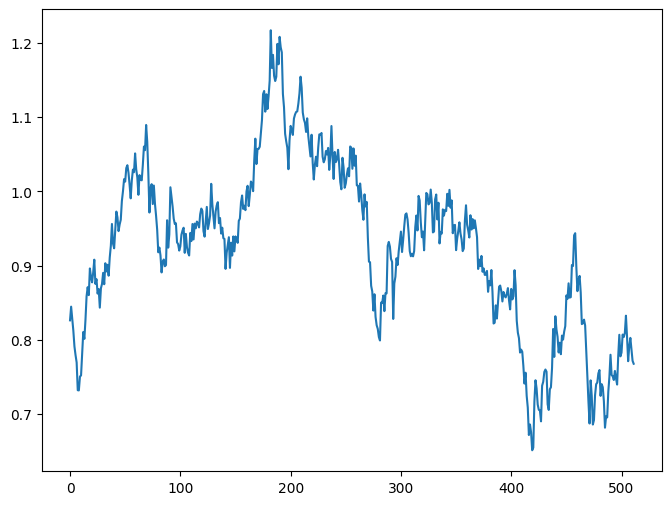

In [23]:
plt.plot(tbatch[0][20][0])

### MAE on the test split for the pretrained TimesFM model

In [26]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    forecasts, _ = tfm.forecast(list(past), [0] * past.shape[0], normalize=True)
    forecasts = forecasts[:, 0 : actuals.shape[1]]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

52it [00:02, 21.66it/s]

MAE: 0.09899035387250757


## View prediction

In [32]:
import sys
sys.path.append("../../TimeseriesPrediction")
#from testing import plot_predictions  genera errore torch


def plot_predictions(dataset, model, num_samples=10):
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    with torch.no_grad():
        indices = np.random.choice(len(dataset) - 1, size=num_samples, replace=False)
        for idx in indices:
            X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed = get_one_prediction(dataset, device, idx, model)

            # Plot
            plt.figure(figsize=(8 ,4))
            plt.plot(range(seq_length), X_inversed[: ,0], label='Input (storico)', color='blue')
            plt.plot(x_future, y_true_inversed[: ,0], label='Valore Reale', color='green')
            plt.plot(x_future, y_pred_inversed[: ,0], label='Predizione', color='red')

            plt.title(f"Example idx={idx} -  horizon={horizon}")
            plt.legend()
            plt.show()

def plot_one_prediction(dataset, model, idx_samples=0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed = get_one_prediction(dataset, device, idx_samples, model)

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(range(seq_length), X_inversed[:, 0], label='Input (storico)', color='blue')
        plt.plot(x_future, y_true_inversed[:, 0], label='Valore Reale', color='green')
        plt.plot(x_future, y_pred_inversed[:, 0], label='Predizione', color='red')

        plt.title(f"Example idx={idx_samples} -  horizon={horizon}")
        plt.legend()
        plt.show()


def get_one_prediction(dataset, device, idx, model):
    X, y_true = dataset[idx]
    X_input = X.unsqueeze(0).float().to(device)  # (1, seq_length, 1)
    y_pred = model(X_input).cpu().numpy()  # (1, horizon)
    # Convertiamoli in numpy
    X = X.squeeze(-1).cpu().numpy()  # shape (seq_length,)
    y_true = y_true.cpu().numpy()  # shape (horizon,)
    y_pred = y_pred.squeeze(0)  # shape (horizon,)
    # Inverse transform
    X_inversed = dataset.scalers_X[idx].inverse_transform(X.reshape(-1, 1))  # .flatten()
    y_true_inversed = dataset.scalers_X[idx].inverse_transform(y_true.reshape(-1, 1))  # .flatten()
    y_pred_inversed = dataset.scalers_X[idx].inverse_transform(y_pred.reshape(-1, 1))  # .flatten()
    seq_length = len(X_inversed)  # p.es. 256
    horizon = len(y_true_inversed)  # p.es. 5
    x_future = np.arange(seq_length, seq_length + horizon)
    return X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_dataset_length(dataset):
    # Prova a ottenere la cardinalità (funziona solo se il dataset ha dimensione nota)
    cardinality = tf.data.experimental.cardinality(dataset)
    if cardinality != tf.data.experimental.UNKNOWN_CARDINALITY:
        return cardinality.numpy()
    else:
        # Conta manualmente gli elementi (più lento)
        count = 0
        for _ in dataset:
            count += 1
        return count
        
def plot_predictions(dataset, model, num_samples=10):
    dataset_length = get_dataset_length(dataset)
    indices = np.random.choice(dataset_length - 1, size=num_samples, replace=False)
    for idx in indices:
        X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed = get_one_prediction(dataset, idx, model)
        
        # Plot
        plt.figure(figsize=(8 ,4))
        plt.plot(range(seq_length), X_inversed[:, 0], label='Input (storico)', color='blue')
        plt.plot(x_future, y_true_inversed[:, 0], label='Valore Reale', color='green')
        plt.plot(x_future, y_pred_inversed[:, 0], label='Predizione', color='red')

        plt.title(f"Example idx={idx} -  horizon={horizon}")
        plt.legend()
        plt.show()

def plot_one_prediction(dataset, model, idx_samples=0):
    X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed = get_one_prediction(dataset, idx_samples, model)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(seq_length), X_inversed[:, 0], label='Input (storico)', color='blue')
    plt.plot(x_future, y_true_inversed[:, 0], label='Valore Reale', color='green')
    plt.plot(x_future, y_pred_inversed[:, 0], label='Predizione', color='red')

    plt.title(f"Example idx={idx_samples} -  horizon={horizon}")
    plt.legend()
    plt.show()


def get_one_prediction(dataset, idx, model):
    X, y_true = dataset[idx]
    X_input = tf.expand_dims(X, axis=0)  # Aggiunge dimensione del batch
    y_pred = model(X_input)
    
    # Converti in numpy
    X = tf.squeeze(X, axis=-1).numpy()  # (seq_length,)
    y_true = y_true.numpy()             # (horizon,)
    y_pred = y_pred.numpy().squeeze(0)  # (horizon,)
    
    # Inverse transform
    X_inversed = dataset.scalers_X[idx].inverse_transform(X.reshape(-1, 1))
    y_true_inversed = dataset.scalers_X[idx].inverse_transform(y_true.reshape(-1, 1))
    y_pred_inversed = dataset.scalers_X[idx].inverse_transform(y_pred.reshape(-1, 1))
    
    seq_length = len(X_inversed)
    horizon = len(y_true_inversed)
    x_future = np.arange(seq_length, seq_length + horizon)
    
    return X_inversed, horizon, seq_length, x_future, y_pred_inversed, y_true_inversed

In [37]:
plot_predictions(test_batches, tfm, num_samples=10)

TypeError: 'PrefetchDataset' object is not subscriptable

## Finetuning the model on the ETT dataset

In [38]:
import jax
from jax import numpy as jnp
from praxis import pax_fiddle
from praxis import py_utils
from praxis import pytypes
from praxis import base_model
from praxis import optimizers
from praxis import schedules
from praxis import base_hyperparams
from praxis import base_layer
from paxml import tasks_lib
from paxml import trainer_lib
from paxml import checkpoints
from paxml import learners
from paxml import partitioning
from paxml import checkpoint_types

In [39]:
# PAX shortcuts
NestedMap = py_utils.NestedMap
WeightInit = base_layer.WeightInit
WeightHParams = base_layer.WeightHParams
InstantiableParams = py_utils.InstantiableParams
JTensor = pytypes.JTensor
NpTensor = pytypes.NpTensor
WeightedScalars = pytypes.WeightedScalars
instantiate = base_hyperparams.instantiate
LayerTpl = pax_fiddle.Config[base_layer.BaseLayer]
AuxLossStruct = base_layer.AuxLossStruct

AUX_LOSS = base_layer.AUX_LOSS
template_field = base_layer.template_field

# Standard prng key names
PARAMS = base_layer.PARAMS
RANDOM = base_layer.RANDOM

key = jax.random.PRNGKey(seed=1234)

In [40]:
model = pax_fiddle.Config(
    patched_decoder.PatchedDecoderFinetuneModel,
    name='patched_decoder_finetune',
    core_layer_tpl=tfm.model_p,
)

### We will hold the transformer layers fixed while finetuning, while training all other components.

In [41]:
@pax_fiddle.auto_config
def build_learner() -> learners.Learner:
  return pax_fiddle.Config(
      learners.Learner,
      name='learner',
      loss_name='avg_qloss',
      optimizer=optimizers.Adam(
          epsilon=1e-7,
          clip_threshold=1e2,
          learning_rate=1e-2,
          lr_schedule=pax_fiddle.Config(
              schedules.Cosine,
              initial_value=1e-3,
              final_value=1e-4,
              total_steps=40000,
          ),
          ema_decay=0.9999,
      ),
      # Linear probing i.e we hold the transformer layers fixed.
      bprop_variable_exclusion=['.*/stacked_transformer_layer/.*'],
  )

In [42]:
task_p = tasks_lib.SingleTask(
    name='ts-learn',
    model=model,
    train=tasks_lib.SingleTask.Train(
        learner=build_learner(),
    ),
)

In [43]:
task_p.model.ici_mesh_shape = [1, 1, 1]
task_p.model.mesh_axis_names = ['replica', 'data', 'mdl']

DEVICES = np.array(jax.devices()).reshape([1, 1, 1])
MESH = jax.sharding.Mesh(DEVICES, ['replica', 'data', 'mdl'])

num_devices = jax.local_device_count()
print(f'num_devices: {num_devices}')
print(f'device kind: {jax.local_devices()[0].device_kind}')

num_devices: 1
device kind: NVIDIA GeForce RTX 3090


In [44]:
jax_task = task_p
key, init_key = jax.random.split(key)

# To correctly prepare a batch of data for model initialization (now that shape
# inference is merged), we take one devices*batch_size tensor tuple of data,
# slice out just one batch, then run the prepare_input_batch function over it.


def process_train_batch(batch):
    past_ts = batch[0].reshape(batch_size * num_ts, -1)
    actual_ts = batch[3].reshape(batch_size * num_ts, -1)
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


def process_eval_batch(batch):
    past_ts = batch[0]
    actual_ts = batch[3]
    return NestedMap(input_ts=past_ts, actual_ts=actual_ts)


jax_model_states, _ = trainer_lib.initialize_model_state(
    jax_task,
    init_key,
    process_train_batch(tbatch),
    checkpoint_type=checkpoint_types.CheckpointType.GDA,
)

### Setting the initial model weights to the pretrained TimesFM parameters.

In [45]:
jax_model_states.mdl_vars['params']['core_layer'] = tfm._train_state.mdl_vars['params']
jax_vars = jax_model_states.mdl_vars
gc.collect()

0

### Training loop

In [46]:
jax_task = task_p


def train_step(states, prng_key, inputs):
  return trainer_lib.train_step_single_learner(
      jax_task, states, prng_key, inputs
  )


def eval_step(states, prng_key, inputs):
  states = states.to_eval_state()
  return trainer_lib.eval_step_single_learner(
      jax_task, states, prng_key, inputs
  )

key, train_key, eval_key = jax.random.split(key, 3)
train_prng_seed = jax.random.split(train_key, num=jax.local_device_count())
eval_prng_seed = jax.random.split(eval_key, num=jax.local_device_count())

p_train_step = jax.pmap(train_step, axis_name='batch')
p_eval_step = jax.pmap(eval_step, axis_name='batch')

In [47]:
replicated_jax_states = trainer_lib.replicate_model_state(jax_model_states)
replicated_jax_vars = replicated_jax_states.mdl_vars

In [52]:
best_eval_loss = 1e7
step_count = 0
patience = 0
NUM_EPOCHS = 10
PATIENCE = 5
TRAIN_STEPS_PER_EVAL = 1000
CHECKPOINT_DIR='./sinus500'

In [53]:
def reshape_batch_for_pmap(batch, num_devices):
  def _reshape(input_tensor):
    bsize = input_tensor.shape[0]
    residual_shape = list(input_tensor.shape[1:])
    nbsize = bsize // num_devices
    return jnp.reshape(input_tensor, [num_devices, nbsize] + residual_shape)

  return jax.tree.map(_reshape, batch)

In [54]:
CHECKPOINT_DIR

'./sinus500'

In [55]:
total_train_loss = []
total_test_loss = []
for epoch in range(NUM_EPOCHS):
    print(f"__________________Epoch: {epoch}__________________", flush=True)
    train_its = train_batches.as_numpy_iterator()
    if patience >= PATIENCE:
        print("Early stopping.", flush=True)
        break
    for batch in tqdm(train_its):
        train_losses = []
        if patience >= PATIENCE:
            print("Early stopping.", flush=True)
            break
        tbatch = process_train_batch(batch)
        tbatch = reshape_batch_for_pmap(tbatch, num_devices)
        replicated_jax_states, step_fun_out = p_train_step(
            replicated_jax_states, train_prng_seed, tbatch
        )
        train_losses.append(step_fun_out.loss[0])
        total_train_loss.append(step_fun_out.loss[0])
        if step_count % TRAIN_STEPS_PER_EVAL == 0:
            print(
                f"Train loss at step {step_count}: {np.mean(train_losses)}",
                flush=True,
            )
            train_losses = []
            print("Starting eval.", flush=True)
            val_its = val_batches.as_numpy_iterator()
            eval_losses = []
            for ev_batch in tqdm(val_its):
                ebatch = process_eval_batch(ev_batch)
                ebatch = reshape_batch_for_pmap(ebatch, num_devices)
                _, step_fun_out = p_eval_step(
                    replicated_jax_states, eval_prng_seed, ebatch
                )
                eval_losses.append(step_fun_out.loss[0])                
            mean_loss = np.mean(eval_losses)
            total_test_loss.append(mean_loss)
            print(f"Eval loss at step {step_count}: {mean_loss}", flush=True)
            if mean_loss < best_eval_loss or np.isnan(mean_loss):
                best_eval_loss = mean_loss
                print("Saving checkpoint.")
                jax_state_for_saving = py_utils.maybe_unreplicate_for_fully_replicated(
                    replicated_jax_states
                )
                checkpoints.save_checkpoint(
                    jax_state_for_saving, CHECKPOINT_DIR, overwrite=True
                )
                patience = 0
                del jax_state_for_saving
                gc.collect()
            else:
                patience += 1
                print(f"patience: {patience}")
        step_count += 1

__________________Epoch: 0__________________


0it [00:00, ?it/s]

Train loss at step 0: 0.9533669352531433
Starting eval.



 [00:00, ?it/s]
 [00:00, 49.76it/s]
t [00:00, 75.37it/s]
31it [00:00, 82.92it/s]

Eval loss at step 0: 0.7555897235870361



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1000it [01:21, 13.93it/s]

Train loss at step 1000: 0.6092524528503418
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.78it/s]
t [00:00, 77.73it/s]
31it [00:00, 85.31it/s]

Eval loss at step 1000: 0.6689457893371582



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1712it [02:21, 12.08it/s]

__________________Epoch: 1__________________



288it [00:21, 12.46it/s]

Train loss at step 2000: 0.6002565622329712
Starting eval.



 [00:00, ?it/s]
 [00:00, 46.02it/s]
t [00:00, 64.52it/s]
31it [00:00, 75.78it/s]


Eval loss at step 2000: 0.6568556427955627


        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1287it [01:42, 11.17it/s]

Train loss at step 3000: 0.6280748248100281
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.75it/s]
t [00:00, 71.99it/s]
31it [00:00, 77.57it/s]

Eval loss at step 3000: 0.6572485566139221



1292it [01:43,  8.74it/s]

patience: 1


1712it [02:14, 12.77it/s]

__________________Epoch: 2__________________



576it [00:42, 14.10it/s]

Train loss at step 4000: 0.7219887971878052
Starting eval.



 [00:00, ?it/s]
 [00:00, 38.85it/s]
t [00:00, 77.39it/s]
31it [00:00, 81.62it/s]

Eval loss at step 4000: 0.6357668042182922



        shapes of train_state  as the unpadded shapes.


Saving checkpoint.


1575it [02:04, 10.93it/s]

Train loss at step 5000: 0.6417380571365356
Starting eval.



 [00:00, ?it/s]
 [00:00, 46.83it/s]
t [00:00, 79.57it/s]
31it [00:00, 84.30it/s]

Eval loss at step 5000: 0.6527819037437439



1580it [02:05,  8.83it/s]

patience: 1


1712it [02:14, 12.70it/s]

__________________Epoch: 3__________________



864it [01:04, 14.24it/s]

Train loss at step 6000: 0.6247949004173279
Starting eval.



 [00:00, ?it/s]
 [00:00, 48.11it/s]
t [00:00, 71.74it/s]
31it [00:00, 82.22it/s]

Eval loss at step 6000: 0.6364588141441345



869it [01:04,  9.57it/s]

patience: 2


1712it [02:07, 13.46it/s]

__________________Epoch: 4__________________



151it [00:11, 14.95it/s]

Train loss at step 7000: 0.5131469964981079
Starting eval.



 [00:00, ?it/s]
 [00:00, 48.69it/s]
t [00:00, 82.51it/s]
31it [00:00, 87.60it/s]

Eval loss at step 7000: 0.6415659189224243



156it [00:11,  9.85it/s]

patience: 3


1151it [01:25, 15.40it/s]

Train loss at step 8000: 0.5717317461967468
Starting eval.



 [00:00, ?it/s]
 [00:00, 39.33it/s]
t [00:00, 72.16it/s]
31it [00:00, 83.88it/s]

Eval loss at step 8000: 0.6561477780342102



1156it [01:26,  9.76it/s]

patience: 4


1712it [02:07, 13.45it/s]

__________________Epoch: 5__________________



439it [00:32,  8.71it/s]

Train loss at step 9000: 0.4807814061641693
Starting eval.



 [00:00, ?it/s]
 [00:00, 46.14it/s]
t [00:00, 73.94it/s]
31it [00:00, 84.61it/s]

Eval loss at step 9000: 0.6523524522781372



441it [00:33,  6.06it/s]

patience: 5
Early stopping.


441it [00:33, 13.28it/s]

__________________Epoch: 6__________________
Early stopping.


In [56]:
train_loss = [t.item() for t in total_train_loss]
test_loss = [t.item() for t in total_test_loss]

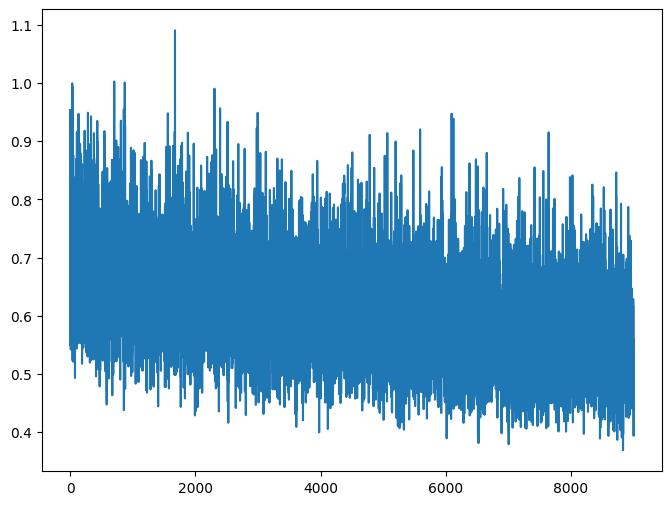

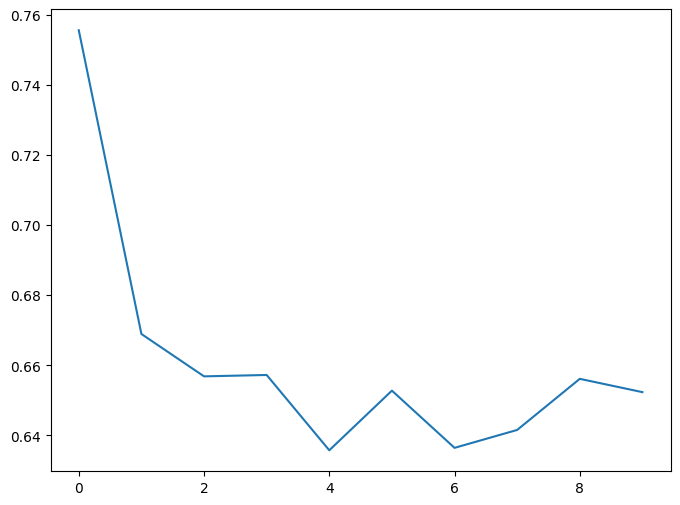

In [58]:
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

## Loading and evaluating the best (according to validation loss) finetuned checkpoint

In [59]:
train_state = checkpoints.restore_checkpoint(jax_model_states, CHECKPOINT_DIR)
print(train_state.step)
tfm._train_state.mdl_vars['params'] = train_state.mdl_vars['params']['core_layer']
tfm.jit_decode()


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


4002
Jitting decoding.
Jitted decoding in 47.41 seconds.


In [62]:
mae_losses = []
for batch in tqdm(test_batches.as_numpy_iterator()):
    past = batch[0]
    actuals = batch[3]
    _, forecasts = tfm.forecast(list(past), [0] * past.shape[0])
    forecasts = forecasts[:, 0 : actuals.shape[1], 5]
    mae_losses.append(np.abs(forecasts - actuals).mean())

print(f"MAE: {np.mean(mae_losses)}")

52it [00:02, 23.19it/s]

MAE: 0.08326950669288635


## There is around a __7%__ reduction in MAE from finetuning.

In [43]:
(0.3303774 - 0.30829155) / 0.3303774

0.06685036567271237